In [82]:
# Plotting and data loading imports used in this notebook
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
from scipy.ndimage import gaussian_filter1d , gaussian_filter

from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
)

Some data sets have unequal length series. Two data sets with this characteristic are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We cannot store unequal length series in numpy arrays. Instead, we use a nested pandas.DataFrame, where each cell is a pandas.Series. This is the default return type for all single problem loaders.

In [83]:
# creo il panda dataframe delle batterie

#importo il database
#list_cells= ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']
#list_cells= ['B0025','B0026','B0027','B0028','B0029','B0030','B0031','B0032','B0033','B0034','B0036','B0038','B0039','B0040']
#list_cells= ['B0006']
list_cells= ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']
list_cells_train= ['B0005','B0007','B0025']
list_cells_test = ['B0006']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('/home/apetrella/Workspace/battery_tsc/dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]

########################################################################à


In [105]:

#divido in 3 parti: charge, discharge e impedance... per ora lavoro solo con charge
nasa_dict={}

# per ogni cella
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []


    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 0):
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' and key > 0):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' and key > 0):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    # porto dato capacity di discharge in charge.. (sono due in meno i discharge..!!!! da sistemare)
    
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #trasformo capacity in SoH
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    
    #trasformo array in panda series# mi serve per sktime
    lunghezze=[]
    for k,v in enumerate(nasa_dict[cell]['charge']):
        #if( len( nasa_dict[cell]['charge'][k]['Temperature_measured']) == 0):
        lunghezze.append(len( nasa_dict[cell]['charge'][k]['Temperature_measured']))
    
    print(max(lunghezze))
    print(min(lunghezze))
    print('-----------')


    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:100])
        nasa_dict[cell]['charge'][k]['Current_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_measured'][:100])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:100])
        nasa_dict[cell]['charge'][k]['Current_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_charge'][:100])
        nasa_dict[cell]['charge'][k]['Voltage_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_charge'][:100])
        nasa_dict[cell]['charge'][k]['Time'] = pd.Series(nasa_dict[cell]['charge'][k]['Time'][:100])

    


# unisco come fosse una cella unica.
nasa_dict_unify={}
nasa_dict_unify['charge'] = []
nasa_dict_unify['discharge'] = []
nasa_dict_unify['impedance'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['discharge']):
        nasa_dict_unify['discharge'].append(v)
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['impedance']):
        nasa_dict_unify['impedance'].append(v)

#print(nasa_dict_unify['charge'])

df= pd.DataFrame.from_dict(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non volgio usare)
df=df.drop("Current_charge",axis=1)
df=df.drop("Current_measured",axis=1)
df=df.drop("Voltage_charge",axis=1)
df=df.drop("Time",axis=1)

df

KeyError: 370

In [78]:
#ripeto per il test

nasa_dict={}


# per ogni cella
for cell in list_cells_test:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []


    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 0):
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' and key > 0):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' and key > 0):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    # porto dato capacity di discharge in charge.. (sono due in meno i discharge..!!!! da sistemare)
    
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #trasformo capacity in SoH
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    
    #trasformo array in panda series# mi serve per sktime
    

    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:100])
        nasa_dict[cell]['charge'][k]['Current_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_measured'][:100])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:100])
        nasa_dict[cell]['charge'][k]['Current_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_charge'][:100])
        nasa_dict[cell]['charge'][k]['Voltage_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_charge'][:100])
        nasa_dict[cell]['charge'][k]['Time'] = pd.Series(nasa_dict[cell]['charge'][k]['Time'][:100])


# unisco come fosse una cella unica.
nasa_dict_unify={}
nasa_dict_unify['charge'] = []
nasa_dict_unify['discharge'] = []
nasa_dict_unify['impedance'] = []

for cell in list_cells_test:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['discharge']):
        nasa_dict_unify['discharge'].append(v)
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['impedance']):
        nasa_dict_unify['impedance'].append(v)

#print(nasa_dict_unify['charge'])

df_test= pd.DataFrame.from_dict(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non volgio usare)
df_test=df_test.drop("Current_charge",axis=1)
df_test=df_test.drop("Current_measured",axis=1)
df_test=df_test.drop("Voltage_charge",axis=1)
df_test=df_test.drop("Time",axis=1)


In [79]:
import numpy as np

#randomize dataframe
#df=df.sample(frac=1, random_state=1).reset_index(drop=True)

np.random.seed(2)
msk = np.random.rand(len(df)) < 0.85


#x_train = df[msk]
x_train = df
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

#x_test = df[~msk]
x_test = df_test
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(369, 2) (369,)
(169, 2) (169,)


In [80]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.dummy import DummyClassifier
from sktime.performance_metrics.forecasting import mean_absolute_error,mean_absolute_percentage_error

MAE% = 0.08182657651632225
MAE = 5.846153846153846
RMSE = 7.784068086568318


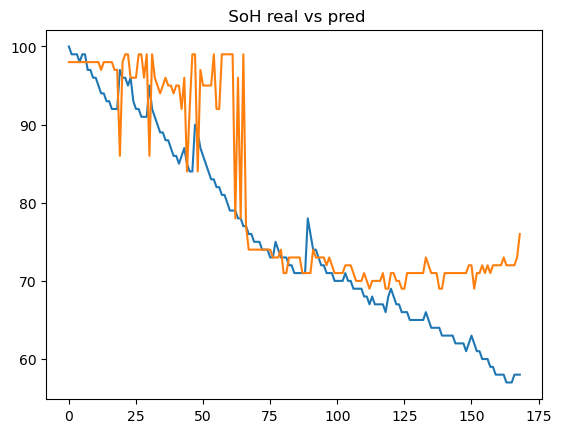

In [81]:


padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5, random_state=1)
#padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_jobs=10)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print('MAE% = ' + str(mean_absolute_percentage_error(y_test, y_pred)))
print('MAE = ' + str(mean_absolute_error(y_test, y_pred)))
print('RMSE = ' + str(np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())))


plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

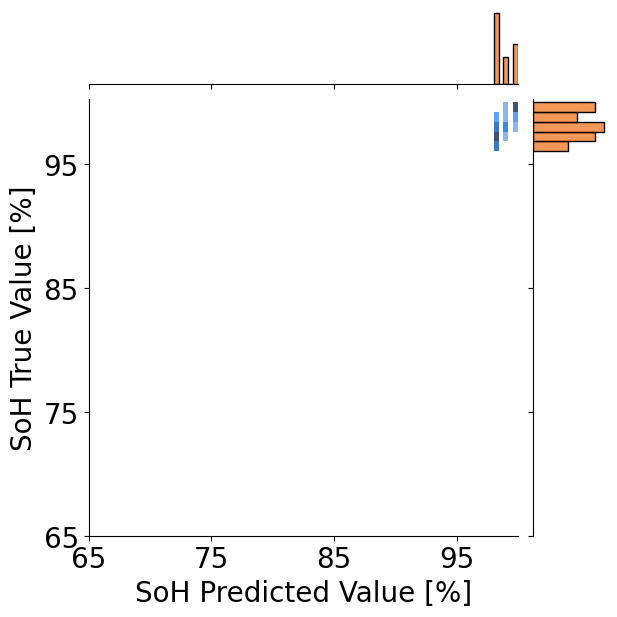

In [70]:

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(65, 101, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
#g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
#g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/cell28_100_nasa_8515.png', dpi=300, bbox_inches="tight")

mae = 14.93233082706767, maep = 0.18455093949478318


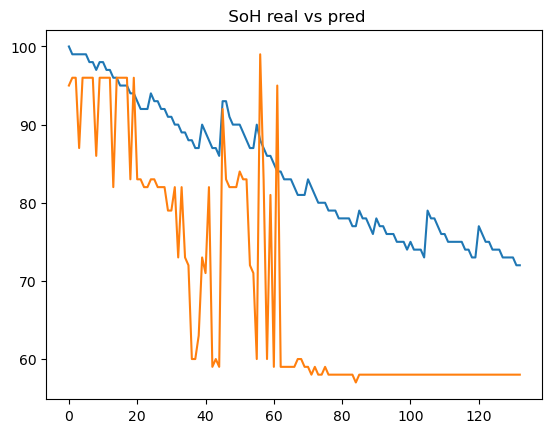

In [11]:
padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=10, random_state=1)
#padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_jobs=10)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
maep= mean_absolute_percentage_error(y_test, y_pred)

print("mae = " + str(mae) + ", maep = " + str(maep))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()


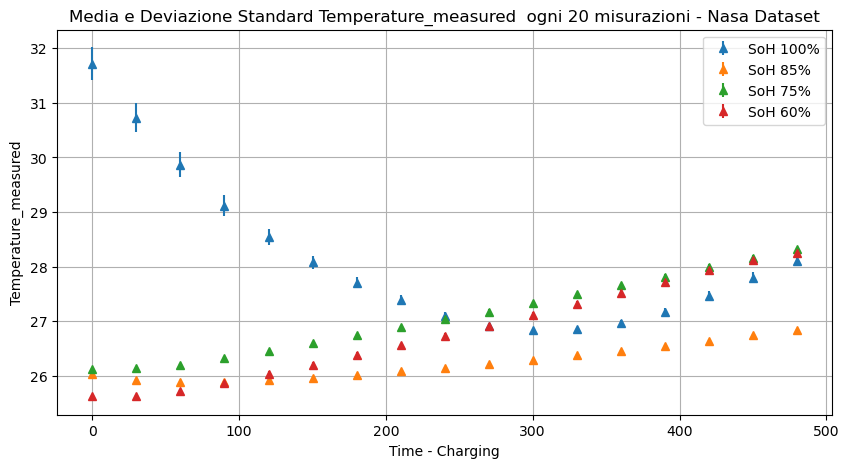

In [11]:
import numpy as np
CELL = 'B0006'
METRIC = 'Temperature_measured'
window_size = 30


# Genera un array di esempio di lunghezza 1000
data0 = nasa_dict[CELL]['charge'][1][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti

means0 = []
std_devs0 = []
for i in range(0, len(data0), window_size):
    window = data0[i:i + window_size]
    means0.append(np.mean(window))
    std_devs0.append(np.std(window))

data70 = nasa_dict[CELL]['charge'][70][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means70 = []
std_devs70 = []
for i in range(0, len(data70), window_size):
    window = data70[i:i + window_size]
    means70.append(np.mean(window))
    std_devs70.append(np.std(window))

data120 = nasa_dict[CELL]['charge'][120][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means120 = []
std_devs120 = []
for i in range(0, len(data120), window_size):
    window = data120[i:i + window_size]
    means120.append(np.mean(window))
    std_devs120.append(np.std(window))

data160 = nasa_dict[CELL]['charge'][160][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means160 = []
std_devs160 = []
for i in range(0, len(data160), window_size):
    window = data160[i:i + window_size]
    means160.append(np.mean(window))
    std_devs160.append(np.std(window))

# Crea gli intervalli per l'asse x
x0 = np.arange(0, len(data0), window_size)
x70 = np.arange(0, len(data70), window_size)
x120 = np.arange(0, len(data120), window_size)
x160 = np.arange(0, len(data160), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0, means0, std_devs0, linestyle='None', marker='^', label='SoH 100%' )
plt.errorbar(x70, means70, std_devs70, linestyle='None', marker='^', label='SoH 85%')
plt.errorbar(x120, means120, std_devs120, linestyle='None', marker='^', label='SoH 75%' )
plt.errorbar(x160, means160, std_devs160, linestyle='None', marker='^', label='SoH 60%')

plt.title('Media e Deviazione Standard '+ METRIC+'  ogni 20 misurazioni - Nasa Dataset')
plt.xlabel('Time - Charging')
plt.ylabel(METRIC)
plt.legend()
plt.grid(True)
plt.show()

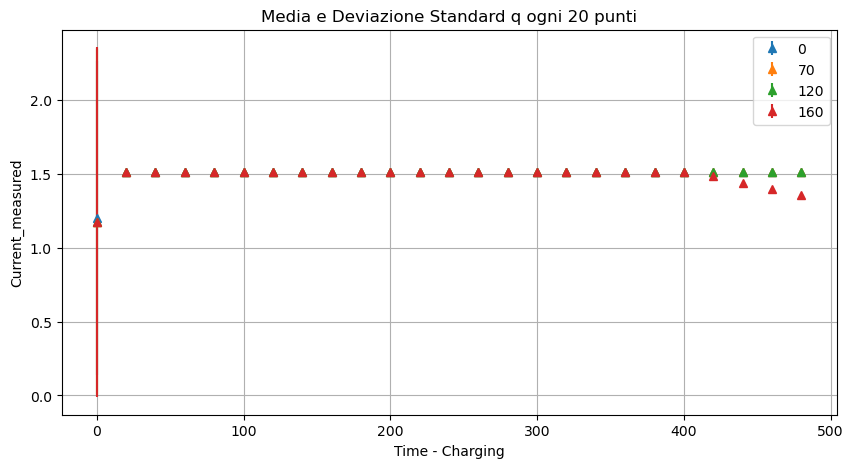

In [36]:
CELL = 'B0006'
METRIC = 'Current_measured'


# Genera un array di esempio di lunghezza 1000
data0 = nasa_dict[CELL]['charge'][1][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 20
means0 = []
std_devs0 = []
for i in range(0, len(data0), window_size):
    window = data0[i:i + window_size]
    means0.append(np.mean(window))
    std_devs0.append(np.std(window))

data70 = nasa_dict[CELL]['charge'][70][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means70 = []
std_devs70 = []
for i in range(0, len(data70), window_size):
    window = data70[i:i + window_size]
    means70.append(np.mean(window))
    std_devs70.append(np.std(window))

data120 = nasa_dict[CELL]['charge'][120][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means120 = []
std_devs120 = []
for i in range(0, len(data120), window_size):
    window = data120[i:i + window_size]
    means120.append(np.mean(window))
    std_devs120.append(np.std(window))

data160 = nasa_dict[CELL]['charge'][160][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means160 = []
std_devs160 = []
for i in range(0, len(data160), window_size):
    window = data160[i:i + window_size]
    means160.append(np.mean(window))
    std_devs160.append(np.std(window))

# Crea gli intervalli per l'asse x
x0 = np.arange(0, len(data0), window_size)
x70 = np.arange(0, len(data70), window_size)
x120 = np.arange(0, len(data120), window_size)
x160 = np.arange(0, len(data160), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0, means0, std_devs0, linestyle='None', marker='^', label='0' )
plt.errorbar(x70, means70, std_devs70, linestyle='None', marker='^', label='70')
plt.errorbar(x120, means120, std_devs120, linestyle='None', marker='^', label='120' )
plt.errorbar(x160, means160, std_devs160, linestyle='None', marker='^', label='160')

plt.title('Media e Deviazione Standard q ogni 20 punti')
plt.xlabel('Time - Charging')
plt.ylabel(METRIC)
plt.legend()
plt.grid(True)
plt.show()

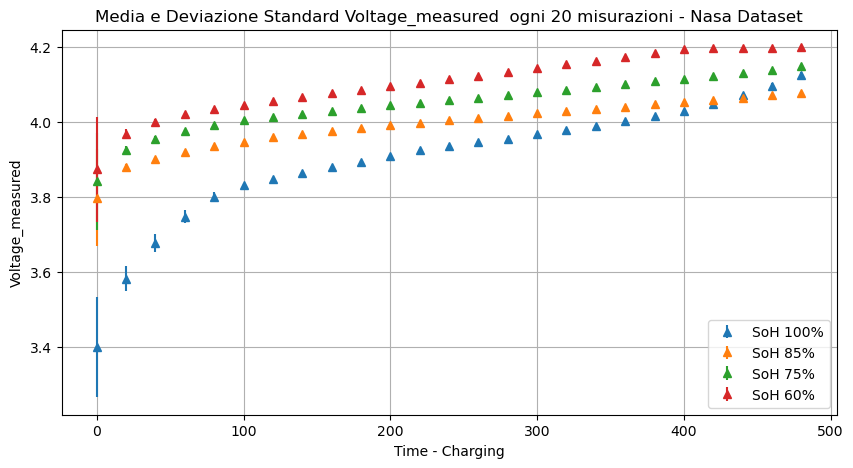

In [10]:
CELL = 'B0006'
METRIC = 'Voltage_measured'


# Genera un array di esempio di lunghezza 1000
data0 = nasa_dict[CELL]['charge'][1][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
window_size = 20
means0 = []
std_devs0 = []
for i in range(0, len(data0), window_size):
    window = data0[i:i + window_size]
    means0.append(np.mean(window))
    std_devs0.append(np.std(window))

data70 = nasa_dict[CELL]['charge'][70][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means70 = []
std_devs70 = []
for i in range(0, len(data70), window_size):
    window = data70[i:i + window_size]
    means70.append(np.mean(window))
    std_devs70.append(np.std(window))

data120 = nasa_dict[CELL]['charge'][120][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means120 = []
std_devs120 = []
for i in range(0, len(data120), window_size):
    window = data120[i:i + window_size]
    means120.append(np.mean(window))
    std_devs120.append(np.std(window))

data160 = nasa_dict[CELL]['charge'][160][METRIC]
# Calcola la media e la deviazione standard ogni 50 punti
means160 = []
std_devs160 = []
for i in range(0, len(data160), window_size):
    window = data160[i:i + window_size]
    means160.append(np.mean(window))
    std_devs160.append(np.std(window))

# Crea gli intervalli per l'asse x
x0 = np.arange(0, len(data0), window_size)
x70 = np.arange(0, len(data70), window_size)
x120 = np.arange(0, len(data120), window_size)
x160 = np.arange(0, len(data160), window_size)


# Plot della media e della deviazione standard
plt.figure(figsize=(10, 5))
plt.errorbar(x0, means0, std_devs0, linestyle='None', marker='^', label='SoH 100%' )
plt.errorbar(x70, means70, std_devs70, linestyle='None', marker='^', label='SoH 85%')
plt.errorbar(x120, means120, std_devs120, linestyle='None', marker='^', label='SoH 75%' )
plt.errorbar(x160, means160, std_devs160, linestyle='None', marker='^', label='SoH 60%')

plt.title('Media e Deviazione Standard '+ METRIC+'  ogni 20 misurazioni - Nasa Dataset')
plt.xlabel('Time - Charging')
plt.ylabel(METRIC)
plt.legend()
plt.grid(True)
plt.show()